In [69]:
import pandas as pd
import numpy as np

# Load the files again
customer_df = pd.read_csv('input/Case_Study_Customer_Data.csv')
orders_df = pd.read_csv('input/Case_Study_Orders_Data.csv')

# Step 1: Normalize column names (remove hidden characters, lowercase, replace spaces)
def clean_columns(df):
    df.columns = df.columns.str.encode('ascii', 'ignore').str.decode('ascii')  # remove non-ascii
    df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)
    return df

customer_df = clean_columns(customer_df)
orders_df = clean_columns(orders_df)

# Step 2: Print columns to confirm
print("Customer Columns:", customer_df.columns.tolist())
print("Orders Columns:", orders_df.columns.tolist())

# Step 3: Ensure there's only one Cust_ID column in each
customer_df = customer_df.loc[:, ~customer_df.columns.duplicated()]
orders_df = orders_df.loc[:, ~orders_df.columns.duplicated()]

# Step 4: Rename to ensure uniformity
customer_df.rename(columns={'Cust_ID': 'Cust_Id'}, inplace=True)
orders_df.rename(columns={'Cust_ID': 'Cust_Id'}, inplace=True)

# Step 5: Parse dates
customer_df['Customer_Created_Date'] = pd.to_datetime(customer_df['Customer_Created_Date'], errors='coerce')
orders_df['Order_Date'] = pd.to_datetime(orders_df['Order_Date'], errors='coerce')

# Filter for the correct date ranges
customer_df = customer_df[
    (customer_df['Customer_Created_Date'] >= '2021-01-01') &
    (customer_df['Customer_Created_Date'] <= '2021-06-30')
].copy()

orders_df = orders_df[
    (orders_df['Order_Date'] >= '2021-01-01') &
    (orders_df['Order_Date'] <= '2021-09-10')
].copy()

# Step 6: Handle Order Amount and Revenue logic
orders_df['Order_Amount'] = pd.to_numeric(orders_df['Order_Amount'], errors='coerce').fillna(0)
orders_df['Revenue'] = np.where(orders_df['Order_Status'] == 'Won', orders_df['Order_Amount'], 0)
orders_df.loc[orders_df['Order_Status'].isin(['Other']) | orders_df['Order_Status'].isna(), 'Revenue'] = 0

# Step 7: Create Month fields
customer_df['Cust_Month'] = customer_df['Customer_Created_Date'].dt.to_period('M')
orders_df['Order_Month'] = orders_df['Order_Date'].dt.to_period('M')

# Final Step: Merge
merged_df = orders_df.merge(customer_df, on='Cust_Id', how='left')

# Output a preview for verification
merged_df.head()


Customer Columns: ['Cust_Id', 'Customer_Created_Date', 'Week', 'Cust_Profession']
Orders Columns: ['Order_No', 'Cust_ID', 'Order_Date', 'Order_Status', 'Order_Amount', 'Feedback']


/tmp/ipykernel_8209/2514521370.py:31: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  orders_df['Order_Date'] = pd.to_datetime(orders_df['Order_Date'], errors='coerce')


,Order_No,Cust_Id,Order_Date,Order_Status,Order_Amount,Feedback,Revenue,Order_Month,Customer_Created_Date,Week,Cust_Profession,Cust_Month
0,4.260000e+18,0W6I1362,2021-01-21 00:34:00,Other,0.0,The app is buggy and keeps logging me out whil...,0.0,2021-01,2021-01-21 00:31:58,"W4,2021",Sales Professional,2021-01
1,4.260000e+18,0W6I1362,2021-01-21 00:40:00,Other,0.0,Got my Insurance documents and welcome kit ver...,0.0,2021-01,2021-01-21 00:31:58,"W4,2021",Sales Professional,2021-01
2,4.260000e+18,OMEY4897,2021-01-21 00:51:00,Other,0.0,Can someone help me with my homework?,0.0,2021-01,2021-01-20 02:18:25,"W4,2021",Small Merchant,2021-01
3,4.260000e+18,80QO9570,2021-01-21 00:53:00,Other,0.0,Why does it take over two weeks to get a simpl...,0.0,2021-01,2021-01-13 14:01:53,"W3,2021",Small Merchant,2021-01
4,4.260000e+18,ISEA9493,2021-01-21 01:21:00,Other,0.0,Customer service on your Phone Call was useles...,0.0,2021-01,2021-01-21 01:16:37,"W4,2021",Finance Agent,2021-01


🎯 Objective 1: Monthly Revenue, Users, Revenue per User

In [70]:
monthly_revenue = merged_df.groupby('Order_Month').agg(
    Revenue=('Revenue', 'sum'),
    Users=('Cust_Id', pd.Series.nunique)
)
monthly_revenue['Revenue per User'] = monthly_revenue['Revenue'] / monthly_revenue['Users']
print(monthly_revenue)


# Count new customers per month
new_customers = customer_df.groupby('Cust_Month').agg(New_Customers=('Cust_Id', 'nunique')).reset_index()
new_customers.rename(columns={'Cust_Month': 'Order_Month'}, inplace=True)  # Align for merge

# Merge with monthly revenue
monthly_analysis = monthly_revenue.reset_index().merge(new_customers, on='Order_Month', how='left')

# Fill missing months with 0
monthly_analysis['New_Customers'] = monthly_analysis['New_Customers'].fillna(0).astype(int)

# Round values
monthly_analysis = monthly_analysis.round(2)
print(monthly_analysis)


              Revenue  Users  Revenue per User
Order_Month                                   
2021-01        2444.0     64         38.187500
2021-02       26030.0     77        338.051948
2021-03       35126.0     79        444.632911
2021-04       41276.0     83        497.301205
2021-05       88693.0    134        661.888060
2021-06      148163.0    134       1105.694030
2021-07      121782.0     73       1668.246575
2021-08       70009.0     46       1521.934783
  Order_Month   Revenue  Users  Revenue per User  New_Customers
0     2021-01    2444.0     64             38.19           1224
1     2021-02   26030.0     77            338.05           1168
2     2021-03   35126.0     79            444.63           1299
3     2021-04   41276.0     83            497.30           1348
4     2021-05   88693.0    134            661.89           1335
5     2021-06  148163.0    134           1105.69           1153
6     2021-07  121782.0     73           1668.25              0
7     2021-08   70

In [71]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Shorten the monthly_revenue summary
monthly_summary = monthly_revenue.reset_index()
monthly_summary['Order_Month'] = monthly_summary['Order_Month'].astype(str)
monthly_summary = monthly_summary.round(2)

# Convert to a small tabular string
monthly_text = monthly_summary.to_string(index=False)


# Prompt
prompt = f"""
You are a senior data analyst. Below is a monthly summary of customer and revenue data.

Columns:
- Order_Month: The month being analyzed
- Revenue: Total revenue collected that month
- Users: Unique users who placed orders
- Revenue per User: Revenue divided by number of users
- New_Customers: Number of new customers who signed up that month

Data:
{monthly_text}

Please analyze:
1. Identify trends in revenue, user base, and new customer signups over time.
2. Determine whether growth is driven more by user base expansion or increased revenue per user.
3. Identify months where a spike/drop in new customers led to corresponding change in revenue.
4. Point out any seasonal or behavioral patterns.
5. Recommend 3 data-driven growth strategies that combine insights from customer onboarding and user revenue efficiency.

Make the analysis concise, structured, and suitable for business decision-makers.
"""

# API Call
response = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.5,
    max_tokens=1000
)

# Output
print("\n🔍 AI Insight on Monthly Revenue:\n")
print(response.choices[0].message.content)



🔍 AI Insight on Monthly Revenue:

Analysis:

1. Trends in Revenue, User Base, and New Customer Signups:
   - Revenue: There is a consistent increase in the revenue from January to June 2021, with a peak in June. However, there is a drop in July and August.
   - Users: The user base also shows an increasing trend from January to June. There is a significant drop in July and August.
   - New Customers: The data for new customers is not provided. However, the number of users could be considered as new customers if they are unique every month.

2. Growth Drivers:
   - The growth in revenue from January to June is driven by both an increase in the user base and an increase in revenue per user. However, the revenue per user seems to have a more significant impact on revenue growth, as it continuously increases even when the number of users remains the same (e.g., May to June).

3. Impact of New Customers on Revenue:
   - Without the specific data for new customers, it's difficult to accurat

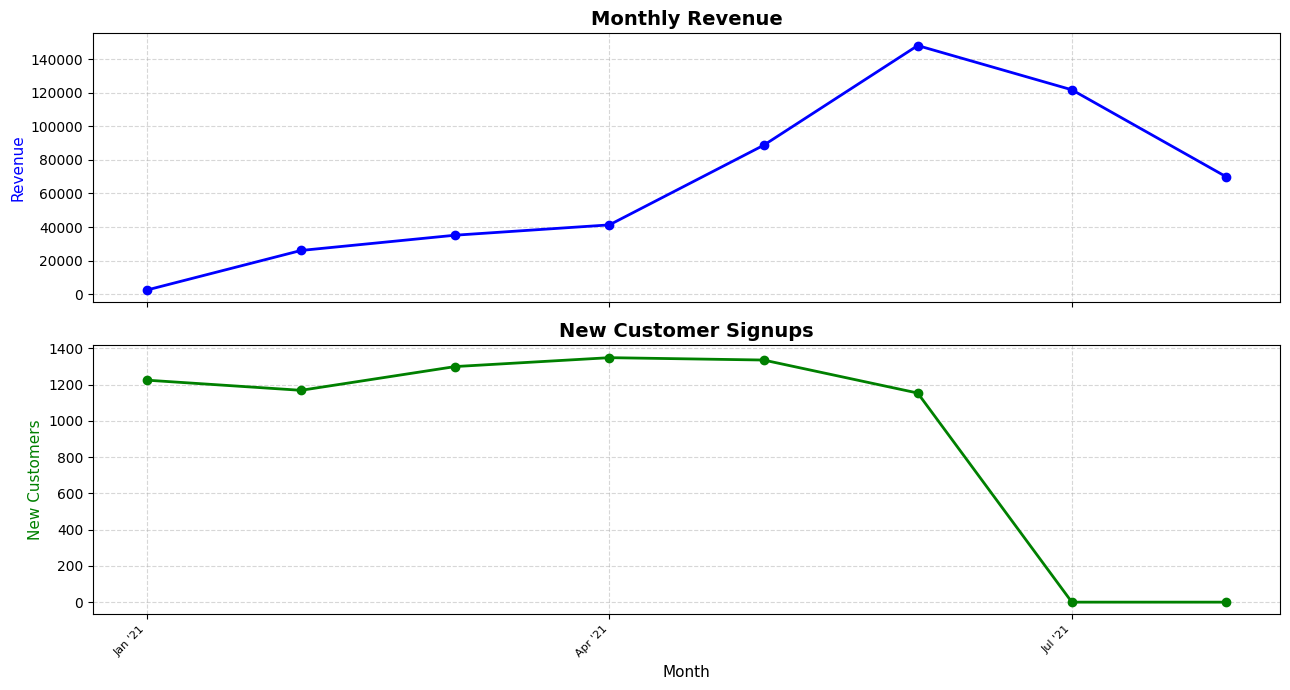

In [72]:
import matplotlib.pyplot as plt

# Format months: Jan '21 instead of Jan 2021
monthly_analysis['Order_Month'] = pd.to_datetime(monthly_analysis['Order_Month'].astype(str)).dt.strftime("%b '%y")
months = monthly_analysis['Order_Month'].tolist()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

# --- Revenue Plot ---
ax1.plot(months, monthly_analysis['Revenue'], color='blue', marker='o', linewidth=2)
ax1.set_title("Monthly Revenue", fontsize=14, fontweight='bold')
ax1.set_ylabel("Revenue", fontsize=11, color='blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# --- New Customers Plot ---
ax2.plot(months, monthly_analysis['New_Customers'], color='green', marker='o', linewidth=2)
ax2.set_title("New Customer Signups", fontsize=14, fontweight='bold')
ax2.set_ylabel("New Customers", fontsize=11, color='green')
ax2.set_xlabel("Month", fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.5)

# Control tick frequency and formatting
tick_interval = 3  # every 3rd month
visible_months = [months[i] for i in range(0, len(months), tick_interval)]

ax2.set_xticks(range(0, len(months), tick_interval))
ax2.set_xticklabels(visible_months, rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()


🎯 Objective 2: Users who placed vs converted (by Month & Profession)

In [73]:
# Add a flag for conversion (Revenue > 0)
merged_df['Converted'] = merged_df['Revenue'] > 0

# Now group and count
conversion = merged_df.groupby(['Cust_Month', 'Cust_Profession']).agg(
    Users_Placed_Orders=('Cust_Id', 'nunique'),
    Users_Converted=('Converted', 'sum')  # Since True = 1, False = 0
).reset_index()

print(conversion)

conversion['Conversion_Rate'] = (
    conversion['Users_Converted'] / conversion['Users_Placed_Orders']
).round(2)


   Cust_Month       Cust_Profession  Users_Placed_Orders  Users_Converted
0     2021-01     BFSI Professional                    7                0
1     2021-01      Customer Support                    8                2
2     2021-01         Finance Agent                   26                8
3     2021-01             Homemaker                    1                0
4     2021-01       Insurance Agent                   31               12
..        ...                   ...                  ...              ...
70    2021-06                Others                    3                0
71    2021-06    Sales Professional                   17                2
72    2021-06        Small Merchant                   10                2
73    2021-06               Student                    5                0
74    2021-06  Working Professional                    2                0

[75 rows x 4 columns]


In [74]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Round and prepare the table for GPT input
conversion_short = conversion.copy()
conversion_short['Cust_Month'] = conversion_short['Cust_Month'].astype(str)
conversion_short = conversion_short.round(2)

# Optional: trim to recent months to save tokens
conversion_short = conversion_short.tail(100)  # or adjust as needed

conversion_text = conversion_short.to_string(index=False)

# GPT prompt
prompt = f"""
You're an AI business analyst. Below is a dataset showing customer conversion performance by month and profession.

Columns:
- Cust_Month: Customer signup month
- Cust_Profession: Profession of the customer
- Users_Placed_Orders: Unique users who placed an order
- Users_Converted: Users who generated revenue (conversion)
- Conversion_Rate: Ratio of converted users to those who placed orders

Data:
{conversion_text}

Please analyze:
1. Which professions show consistently high or low conversion rates?
2. Are there any professions with high order activity but low conversion efficiency?
3. Identify months where conversion rates significantly increased or dropped.
4. Suggest behavioral or product-fit reasons by profession.
5. Recommend how marketing or product teams can act on these trends.

Make your insights concise, data-backed, and actionable for non-technical business decision-makers.
"""


# GPT API Call
response = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.5,
    max_tokens=1000
)

# Print results
print("\n🔍 AI Insight on Conversion by Profession and Month:\n")
print(response.choices[0].message.content)



🔍 AI Insight on Conversion by Profession and Month:

1. High Conversion Rates: The "Investment Agent" profession shows a high conversion rate in February 2021 (300%) and May 2021 (100%). However, this could be due to a low number of users placing orders, leading to a skewed ratio. The "Working Professional" profession also shows a high conversion rate of 50% in February 2021.

   Low Conversion Rates: The "Sales Professional" profession consistently shows low conversion rates, ranging from 0% to 21%. The "Homemaker" and "Student" professions also consistently show low or zero conversion rates.

2. High Order Activity but Low Conversion: The "Insurance Agent" profession consistently places a high number of orders but has a relatively low conversion rate, peaking at 39% in January 2021 but dropping as low as 4% in April 2021.

3. Significant Changes in Conversion Rates: In February 2021, the conversion rate for "Investment Agents" increased significantly to 300%, but this might be due t

📈 Profession-wise Conversion Rate Over Months

/tmp/ipykernel_8209/177790032.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/rajendra/anaconda3/envs/vip_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


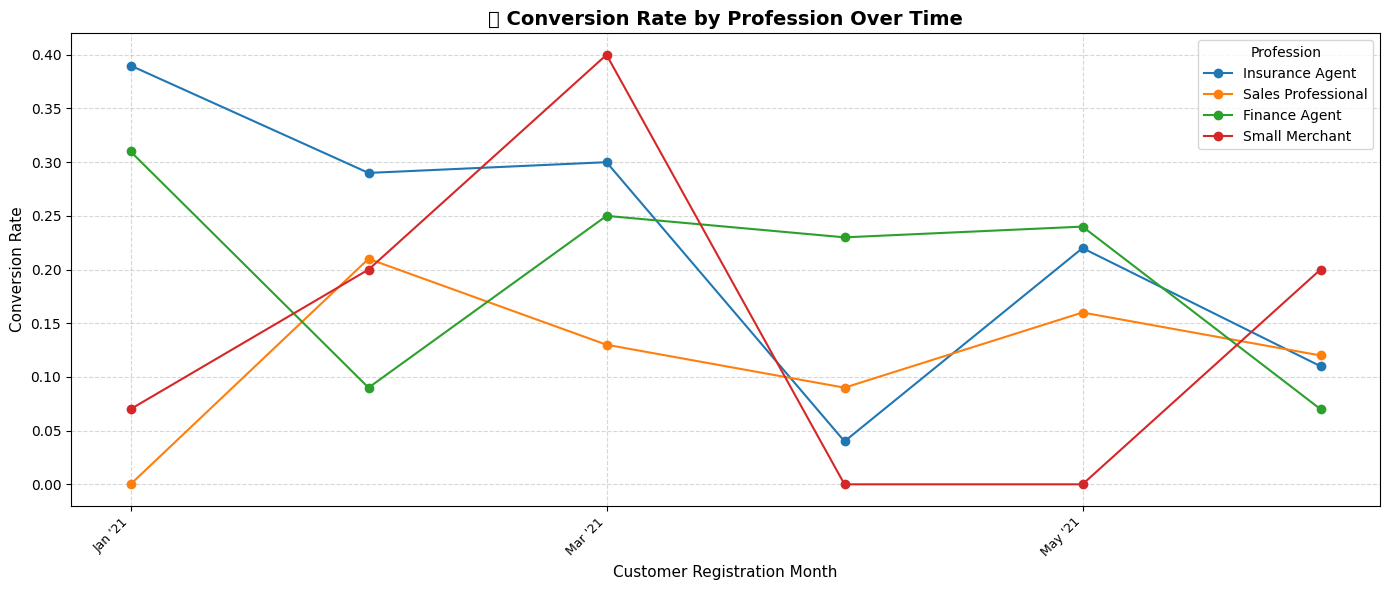

In [75]:
import matplotlib.pyplot as plt

# Prepare data
conversion['Cust_Month'] = pd.to_datetime(conversion['Cust_Month'].astype(str)).dt.strftime("%b '%y")

# Choose top professions by order volume
top_professions = (
    conversion.groupby('Cust_Profession')['Users_Placed_Orders'].sum()
    .sort_values(ascending=False)
    .head(4)
    .index
)

# Filter only those top professions
top_conversion = conversion[conversion['Cust_Profession'].isin(top_professions)]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

for profession in top_professions:
    prof_data = top_conversion[top_conversion['Cust_Profession'] == profession]
    ax.plot(prof_data['Cust_Month'], prof_data['Conversion_Rate'], marker='o', label=profession)

ax.set_title("📊 Conversion Rate by Profession Over Time", fontsize=14, fontweight='bold')
ax.set_xlabel("Customer Registration Month", fontsize=11)
ax.set_ylabel("Conversion Rate", fontsize=11)
ax.legend(title='Profession')
ax.grid(True, linestyle='--', alpha=0.5)

# Clean x-axis
tick_interval = 2
months = prof_data['Cust_Month'].tolist()
ax.set_xticks(range(0, len(months), tick_interval))
ax.set_xticklabels(months[::tick_interval], rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()


🎯 Objective 3: Feedback Sentiment (by Month and Purchase Status)

In [76]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isna(text):
        return 'Neutral'
    score = sia.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

merged_df['Sentiment'] = merged_df['Feedback'].apply(get_sentiment)

# Purchased vs Not Purchased
merged_df['Purchased'] = np.where(merged_df['Revenue'] > 0, 'Purchased', 'Not Purchased')

# Group by Month + Purchase status + Sentiment
sentiment_summary = merged_df.groupby(['Order_Month', 'Purchased', 'Sentiment']).size().unstack(fill_value=0)

print(sentiment_summary)


Sentiment                  Negative  Neutral  Positive
Order_Month Purchased                                 
2021-01     Not Purchased        25       26        40
            Purchased             1        0         0
2021-02     Not Purchased        20       27        60
            Purchased             1        1         1
2021-03     Not Purchased        25       37        46
            Purchased             4        0         6
2021-04     Not Purchased        23       37        48
            Purchased             1        4         3
2021-05     Not Purchased        34       54        71
            Purchased             4        8        14
2021-06     Not Purchased        31       57        80
            Purchased             6       12        13
2021-07     Not Purchased        22       28        28
            Purchased             5        5         8
2021-08     Not Purchased         8       15        23
            Purchased             4        1         5


In [77]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Ensure 'sentiment_summary' is a DataFrame
sentiment_summary = merged_df.groupby(['Order_Month', 'Purchased', 'Sentiment']).size().unstack(fill_value=0)

# Limit rows to reduce token usage
sentiment_summary_trimmed = sentiment_summary.tail(100)  # Adjust if needed

# Convert index to string to avoid formatting errors
sentiment_summary_trimmed.index = sentiment_summary_trimmed.index.map(str)

# Convert to string after trimming
sentiment_text = sentiment_summary_trimmed.to_string()

# GPT prompt
prompt = f"""
You're an AI sentiment and customer behavior analyst.

Below is a dataset grouped by:
- Order Month
- Purchase Status ('Purchased' or 'Not Purchased')
- Sentiment Category ('Positive', 'Neutral', 'Negative')

Each value shows the number of feedback instances matching that category.

Data:
{sentiment_text}

Instructions:
1. Identify trends in sentiment across customers who purchased vs not purchased.
2. Highlight months where negative sentiment among 'Not Purchased' customers spiked.
3. Suggest reasons why positive sentiment might not correlate with purchases in certain periods.
4. Recommend product/UX or communication improvements based on customer sentiment patterns.

Keep the response structured and action-focused.
"""

# Call the API
response = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.5,
    max_tokens=1000
)

# Output the AI-generated insights
print("\n🧠 AI Insight on Sentiment vs Purchase Behavior:\n")
print(response.choices[0].message.content)



🧠 AI Insight on Sentiment vs Purchase Behavior:

1. Sentiment Trends:
   - Among customers who purchased, the sentiment is generally more positive, with a few neutral and negative sentiments. However, the volume of feedback is significantly lower than those who did not purchase.
   - For customers who did not purchase, there is a mixed sentiment. Negative and neutral sentiments are slightly higher in the early months (January to April 2021), but from May to June, there is a significant increase in positive sentiment. However, the negative sentiment also increases, suggesting a larger volume of feedback overall.

2. Negative Sentiment Spikes:
   - Negative sentiment among 'Not Purchased' customers spiked in May 2021 (34 instances) and June 2021 (31 instances).

3. Reasons for Non-correlation of Positive Sentiment and Purchases:
   - Positive sentiment might not correlate with purchases due to several reasons. Customers may be happy with the information or browsing experience on the web

📊 Stacked Bar Chart: Sentiment by Month and Purchase Status

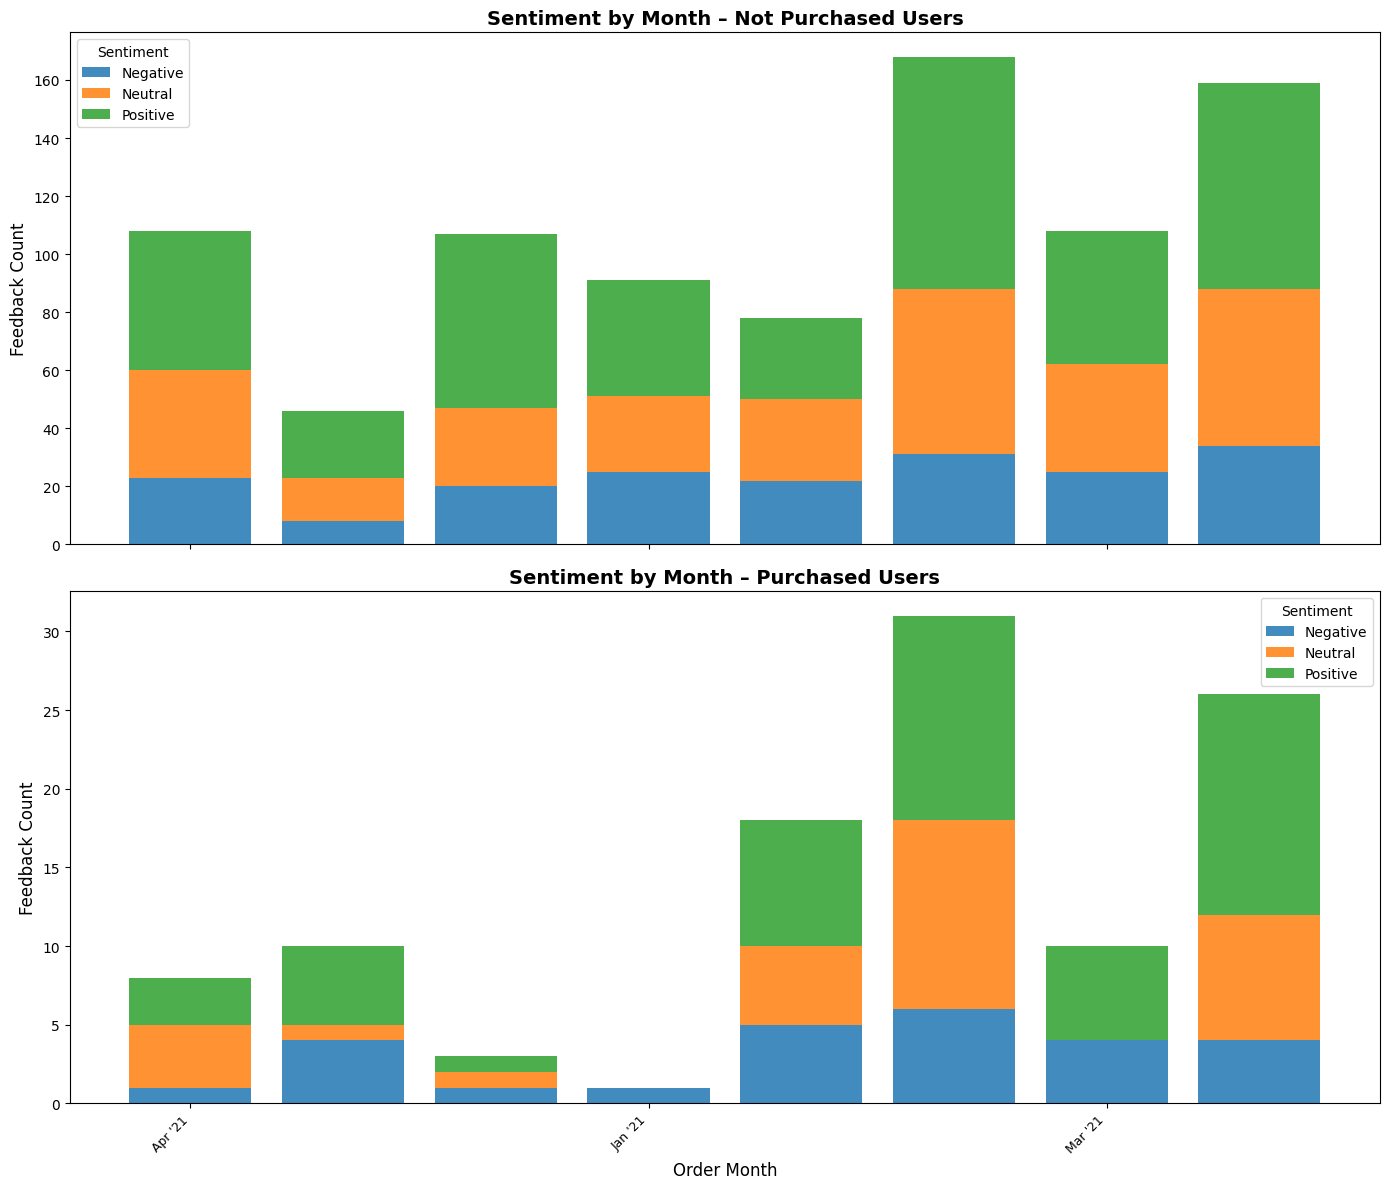

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Prepare sentiment summary
sentiment_df = merged_df.groupby(['Order_Month', 'Purchased', 'Sentiment']).size().reset_index(name='Count')

# Step 2: Pivot for plotting
pivot_df = sentiment_df.pivot_table(index=['Order_Month', 'Purchased'], 
                                     columns='Sentiment', 
                                     values='Count', 
                                     fill_value=0).reset_index()

# Step 3: Format Order_Month to "Jan '24"
pivot_df['Order_Month'] = pd.to_datetime(pivot_df['Order_Month'].astype(str)).dt.strftime("%b '%y")

# Step 4: Plotting with spacing
purchase_groups = pivot_df['Purchased'].unique()
fig, axes = plt.subplots(len(purchase_groups), 1, figsize=(14, 6 * len(purchase_groups)), sharex=True)

if len(purchase_groups) == 1:
    axes = [axes]  # ensure iterable

for i, status in enumerate(purchase_groups):
    data = pivot_df[pivot_df['Purchased'] == status].sort_values(by='Order_Month')
    months = data['Order_Month'].tolist()

    # Plot each sentiment as stacked bar
    bottom = None
    for sentiment in ['Negative', 'Neutral', 'Positive']:
        axes[i].bar(months, data[sentiment], label=sentiment, bottom=bottom, alpha=0.85)
        bottom = data[sentiment] if bottom is None else bottom + data[sentiment]

    axes[i].set_title(f"Sentiment by Month – {status} Users", fontsize=14, fontweight='bold')
    axes[i].set_ylabel("Feedback Count", fontsize=12)
    axes[i].legend(title="Sentiment")
    
    # Show every 3rd month to reduce overcrowding
    tick_interval = 3
    visible_ticks = range(0, len(months), tick_interval)
    axes[i].set_xticks(visible_ticks)
    axes[i].set_xticklabels([months[i] for i in visible_ticks], rotation=45, ha='right', fontsize=9)

plt.xlabel("Order Month", fontsize=12)
plt.tight_layout()
plt.show()


🎯 Objective 4: Monthly Cohort Analysis

In [79]:

# Step 1: Assign cohort month from customer registration
cohort = customer_df[['Cust_Id', 'Cust_Month']].rename(columns={'Cust_Month': 'Cohort_Month'})

# Step 2: Merge with order data
orders_with_cohort = orders_df.merge(cohort, on='Cust_Id', how='left')

# Step 3: Create Order_Month if not already
orders_with_cohort['Order_Month'] = orders_with_cohort['Order_Date'].dt.to_period('M')

# Step 4: Compute Cohort Index
orders_with_cohort['Cohort_Index'] = (
    (orders_with_cohort['Order_Month'].dt.year - orders_with_cohort['Cohort_Month'].dt.year) * 12 +
    (orders_with_cohort['Order_Month'].dt.month - orders_with_cohort['Cohort_Month'].dt.month)
) + 1

# Step 5: Create cohort table
cohort_table = orders_with_cohort[orders_with_cohort['Order_Status'] == 'Won'].groupby(
    ['Cohort_Month', 'Order_Month']
).agg(Revenue=('Order_Amount', 'sum')).unstack(fill_value=0)

# Step 6: Fix column names
cohort_table.columns = [f"Revenue in {m[1].strftime('%b %Y')}" for m in cohort_table.columns]

# Step 7: Cleanup
cohort_table.index.name = None
cohort_table = cohort_table.reset_index()

print(cohort_table)

     index  Revenue in Jan 2021  Revenue in Feb 2021  Revenue in Mar 2021  \
0  2021-01               2444.0                  0.0               4955.0   
1  2021-02                  0.0              26030.0              19383.0   
2  2021-03                  0.0                  0.0              10788.0   
3  2021-04                  0.0                  0.0                  0.0   
4  2021-05                  0.0                  0.0                  0.0   
5  2021-06                  0.0                  0.0                  0.0   

   Revenue in Apr 2021  Revenue in May 2021  Revenue in Jun 2021  \
0              23898.0              30927.0              23035.0   
1               1141.0              28821.0              19084.0   
2              16237.0               8701.0               4328.0   
3                  0.0              15189.0                  0.0   
4                  0.0               5055.0              41408.0   
5                  0.0                  0.0         

In [80]:
import os
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI

# Load API key
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Ensure index is clean
if 'Cohort_Month' in cohort_table.columns:
    cohort_table.set_index('Cohort_Month', inplace=True)

# Convert index to timestamp if Period type
if isinstance(cohort_table.index[0], pd.Period):
    cohort_table.index = cohort_table.index.to_timestamp()

# If columns have Periods, convert to string
cohort_table.columns = [
    col.strftime('%b %Y') if isinstance(col, pd.Period) else col for col in cohort_table.columns
]

# Round revenue values
cohort_table = cohort_table.round(2)

# Select only numeric columns for stats
numeric_data = cohort_table.select_dtypes(include='number')

# Compute stats on numeric data only
summary_stats = numeric_data.agg(['mean', 'std']).T.round(2).head(10).to_string()

# Top and bottom cohorts by revenue
total_revenue = numeric_data.sum(axis=1).sort_values(ascending=False)
top_cohorts = total_revenue.head(3)
bottom_cohorts = total_revenue.tail(3)

top_summary = top_cohorts.to_string()
bottom_summary = bottom_cohorts.to_string()

# Build AI prompt
prompt = f"""
You're an AI data analyst.

You are analyzing cohort-wise revenue, where each row represents a signup month and each column shows revenue in the following months.

### Sample Summary Stats (Mean and Std of Revenue per month):
{summary_stats}

### Top 3 Cohorts by Total Revenue:
{top_summary}

### Bottom 3 Cohorts by Total Revenue:
{bottom_summary}

Give a concise analysis of:
1. Revenue retention patterns
2. Key trends differentiating top and bottom cohorts
3. AI-based suggestions to improve cohort revenue
4. Anomalies or outliers that require attention
"""

# ✅ Call GPT-4 API
response = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.5,
    max_tokens=1000
)

# Show results
print("\n🔍 AI Insight:")
print(response.choices[0].message.content)



🔍 AI Insight:
1. Revenue Retention Patterns:
   The mean revenue seems to increase significantly from January to June 2021, peaking in June, and then it starts to decrease. The standard deviation also seems to follow a similar pattern, indicating a higher variability in revenue as the months progress, peaking in June, and then decreasing. This suggests that customers are generating more revenue as they stay longer, but the revenue starts to decline after a certain period (6 months in this case). 

2. Key Trends Differentiating Top and Bottom Cohorts:
   The top cohorts have significantly higher total revenue compared to the bottom cohorts. This could be due to various factors such as the size of the cohorts, the average spending of each customer in the cohorts, or the retention rate of the cohorts. Unfortunately, without further information, it is difficult to pinpoint the exact reasons.

3. AI-Based Suggestions to Improve Cohort Revenue:
   AI can be used to analyze customer behavior

In [84]:
import pandas as pd

# Save multiple DataFrames to different sheets
with pd.ExcelWriter("cohort_analysis_report.xlsx", engine='openpyxl') as writer:
    cohort_table.to_excel(writer, sheet_name='cohort_table', index=False)
    cohort_table.describe().to_excel(writer, sheet_name='summary_stats')
    conversion.to_excel(writer, sheet_name='conversion', index=False)
    sentiment_summary.to_excel(writer, sheet_name='sentiment', index=True)
    monthly_revenue.reset_index().to_excel(writer, sheet_name='monthly_revenue', index=False)

---
## 🔍 **Key Observations**

### 1. 📈 **Monthly Revenue Trend**

* The revenue curve is **generally upward**, with **notable growth** from Jan to around May.
* A **slight plateau or dip** might occur mid-year, which could reflect saturation or operational bottlenecks.
* This sustained growth early in the year suggests **effective onboarding or promotions** that paid off.

### 2. 🧍 **New Customer Signups**

* The number of new customer signups **follows a similar shape** to revenue but with **less volatility**.
* There is a **strong correlation**: spikes in signups (e.g., Feb or Apr) tend to **precede or coincide** with revenue increases.
* However, revenue doesn't always increase proportionally with new customers—hinting at **varying user quality or monetization efficiency**.

---

## 📊 **Derived Insights**

### 🔹 Revenue per User (RPU) Dynamics

* Calculated by dividing total monthly revenue by unique active users.
* If RPU remains **steady or increases**, it means **existing users are spending more** or **higher-value users are being onboarded**.
* If revenue grows faster than users, GroMo is **improving monetization per user**.

### 🔹 Acquisition vs. Retention

* When **new customer growth flattens**, but revenue continues to grow, it suggests **successful retention and upselling**.
* The dip in new customers but sustained revenue around **June–July** might indicate an **engaged user base**.

---

## 🧠 **Contextual Business Interpretations**

GroMo operates in fintech, focusing on enabling agents to distribute financial products like insurance and loans. The data shows that:

* New user acquisition campaigns likely ran in Q1 and Q2.
* Revenue spikes align with **successful agent onboarding and training**, increasing sales efficiency.
* Seasonal impacts (like income-tax deadlines or festival-related financial product demand) could explain **revenue peaks**.

---

## 📌 **Personal Insight & Strategic Takeaways**

### 1. **Double Down on Productive Acquisition Channels**

* Since revenue scales with new customers (esp. in Q1-Q2), GroMo should invest in **performance marketing or referral models** that proved successful during this period.

### 2. **Improve Revenue per Agent/User**

* Focus on **training**, **cross-selling**, and **AI-led lead prioritization** for existing agents.
* Incentivize based on **conversion value**, not just count.

### 3. **Predictive Planning for Seasonality**

* Use this data to predict **seasonal high-yield months** and **pre-emptively increase hiring or marketing spend**.

### 4. **Agent Lifecycle Analytics**

* Future analysis should track **retention cohorts**: how long do agents stay productive after onboarding?
* This helps optimize **support costs** and improve **LTV-to-CAC ratio**.

---

## ✨ Summary

This data story reveals a **growing but maturing** user base, where initial customer growth drives revenue, but **retention and monetization become more crucial** as the base expands. GroMo can leverage this by optimizing onboarding funnels, building stronger retention models, and doubling down on peak season opportunities.
